In [3]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tqdm
import scipy
from scipy import signal
from tqdm import tnrange
import seaborn as sns
from scipy.stats import norm,entropy,linregress
from scipy.optimize import minimize, curve_fit
from scipy.io import savemat
import multiprocess as mp
from multiprocess import Pool
import sys
import warnings
warnings.filterwarnings('ignore')
#sns.set_context('talk')
#sns.set_style('whitegrid')
cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']

modulename = 'multiprocess' #essing

if modulename in sys.modules:
    print(modulename, 'has been already imported')
#cmap = plt.rcParams['axes.prop_cycle'].by_key()['color']

def calc_plam(num_pulses,lam1,lam2):
    pow_lam1 = np.power(lam1,num_pulses)
    pow_lam2 = np.power(lam2,num_pulses)
    exp_lam1 = np.exp(-lam1)
    exp_lam2 = np.exp(-lam2)
    return pow_lam1*exp_lam1/(pow_lam1*exp_lam1+pow_lam2*exp_lam2)

def compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np):
    sig_Nps = sig_Np[Nps-1]
    sig = np.sqrt(sig_Nps**2+sig_dN**2)
    phigh = norm.cdf((Nps-Nb)/sig)
    pcorrect = (1-choices)+(choices*2-1)*phigh
    return pcorrect

def compute_phigh(Np,Nb,sig_dN,sig_Np):
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_sq(Np,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_phigh_lin(Np,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18):
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    sig = np.sqrt(sig_Np**2+sig_dN**2)
    phigh = norm.cdf((Np-Nb)/sig)
    return phigh

def compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig,Nmin=1,Nmax=18):
    sig_Np = np.sqrt(ksig*(np.arange(Nmin,Nmax+1)))
    return compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)
    
def compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np):
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def compute_logp_correct_lin(choices,Nps,Nb,sig_dN,ksig,sig_0,Nmin=1,Nmax=18):
    sig_Np = ksig*(np.arange(Nmin,Nmax+1)) + sig_0
    pcorrect = compute_pcorrect(choices,Nps,Nb,sig_dN,sig_Np)
    log_pcorrect = np.log(pcorrect)
    return log_pcorrect.sum()

def get_pulses(choices,cum_odor,min_pulse,max_pulse):
    all_Nps = np.ceil(cum_odor).astype(np.int)
    ind_selected = np.logical_and(all_Nps>=min_pulse,all_Nps<=max_pulse)
    return choices[ind_selected], all_Nps[ind_selected]

def get_odor_profile_actual(odor_profile):
    kernel = np.load('odor_kernel_50ms.npy')
    pulse_onsets = (np.diff(odor_profile)>0).astype(np.float)
    pulse_onsets_shifted = np.concatenate((np.zeros((70,)),pulse_onsets,np.zeros(131)))
    odor_profile_actual = np.convolve(pulse_onsets_shifted,kernel,mode='same')
    return odor_profile_actual

def get_conv_odor(session):
    num_trials = session['num_trials']
    conv_odor = np.zeros((num_trials,5000))
    conv_weights_all = np.zeros((num_trials,5000))
    sniff_kernel = np.load('inhalation_kernel_fine_weights_active.npy')
    sniff_kernel = sniff_kernel/sniff_kernel.mean()
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,3,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        conv_weights = np.zeros((10000,))
        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            conv_weights[sniff_onset[i]:sniff_onset[i+1]] = scipy.signal.resample(sniff_kernel,nsample)*250/nsample
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        conv_weights_sampling_epoch = conv_weights[2500:7500]
        odor_command = session['trial_odor'][i_trial]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        odor_effective = odor*conv_weights_sampling_epoch
        conv_odor[i_trial,:] = odor_effective
        conv_weights_all[i_trial,:] = conv_weights_sampling_epoch
    return conv_odor, conv_weights_all

def get_sniff_durations(session):
    num_trials = session['num_trials']
    sniff_durations = np.zeros((num_trials,50))
    for i_trial in range(num_trials):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,3,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = scipy.signal.find_peaks(-sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        sniff_duration = np.diff(sniff_onset)
        sniff_durations[i_trial,:len(sniff_duration)] = sniff_duration
    return sniff_durations

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = scipy.signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y

multiprocess has been already imported


In [4]:
# compute psychjometrics of each animal

num_bins = 20
half_num_bins = 8
min_pulse = 1
max_pulse = 20

pulse_bins = np.linspace(min_pulse,max_pulse,max_pulse-min_pulse+1)
phigh_list = list()
performance_list = list()
bin_counts_list = list()
all_high_choices_list = list()
all_cum_odor_list = list()
all_cum_conv_odor_list = list()
all_correct_trials_list = list()
all_sniff_durations_list = list()

path = os.getcwd() + '/Session/'
savepath = os.getcwd() + '/Figures/'
dir_list = os.listdir(path)


#animals = ['Shorthair']
#animal_list = [['Tabby']]
animal_list = [['Tabby'],['Bengal'],['Shorthair'],['Banner'],['Natasha'],['Stark'],['Peterparker']] #]#['Bengal'],['Shorthair'],['Tabby'],

for animals in animal_list:
    fname_list = list()

    for date_number in range(20190419,20220526):
        for animal in animals:
            for session_id in range(0,10):
                session_string = str(session_id)
                date_string = str(date_number)
                fname = 'session_' + animal + '_' + date_string + '_' + str(session_id) + '.pickle'
                cell_fname = path + fname
                if os.path.isfile(cell_fname):
                    fname_list.append(fname)
                    
#print(fname_list)                    

    num_all_trials = 0
    
    all_trial_odor = np.zeros((0,5000))
    all_conv_weights = np.zeros((0,5000))
    all_conv_odor = np.zeros((0,5000))
    all_cum_odor = np.zeros((0,))
    all_cum_conv_odor = np.zeros((0,))
    all_high_trials = np.zeros((0,))
    all_high_choices = np.zeros((0,))
    all_correct_trials = np.zeros((0,))
    all_sniff_durations = np.zeros(0,)
    for i_file in tnrange(len(fname_list)):
        #session_id = 0
        fnamex = fname_list[i_file]
        #print(fnamex)
        session_fname = path + fnamex
        if os.path.isfile(session_fname):
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
                
                print(session_list[0]['type'])
                
                if session_list[0]['type'] == 'random':
                    if session_list[0]['delay_time'] == 5:
                        if round(session_list[0]['high_count']/session_list[0]['low_count']) == 3:
                            if session_list[0]['low_count'] < 5:
                                num_trials = session['num_trials']
                                session['conv_trial_odor'],session['conv_weights'] = get_conv_odor(session)
                                session['sniff_durations'] = get_sniff_durations(session)
                                conv_fname = 'conv_' + fnamex
                                conv_session_list = list()
                                conv_session_list.append(session)
                                #print(conv_session_list)
                                with open(conv_fname,'wb') as handle:
                                    pickle.dump(session,handle,pickle.HIGHEST_PROTOCOL)


                                non_idle_trials = np.invert(session['idle_trials'])


                                correct_trials = session['correct_trials'][non_idle_trials]
                                high_trials = session['high_trials'][non_idle_trials]
                                low_trials = session['low_trials'][non_idle_trials]
                                high_choices = (correct_trials==high_trials)
                                trial_odor = session['trial_odor'][non_idle_trials]
                                conv_odor = session['conv_trial_odor'][non_idle_trials]
                                conv_weights = session['conv_weights'][non_idle_trials]
                                sniff_durations = session['sniff_durations'][non_idle_trials]
                                sniff_durations = sniff_durations[sniff_durations>0]
                                cum_odor = trial_odor.sum(axis=1)/5000
                                cum_conv_odor = conv_odor.sum(axis=1)/50


                                all_conv_odor = np.append(all_conv_odor, conv_odor, axis=0)
                                all_trial_odor = np.append(all_trial_odor, trial_odor[:,:5000], axis=0)
                                all_conv_weights = np.append(all_conv_weights, conv_weights, axis=0)
                                all_correct_trials = np.append(all_correct_trials,correct_trials)
                                all_high_trials = np.append(all_high_trials,high_trials)
                                all_high_choices = np.append(all_high_choices,high_choices)
                                all_cum_odor = np.append(all_cum_odor,cum_odor)
                                all_cum_conv_odor = np.append(all_cum_conv_odor,cum_conv_odor)
                                all_sniff_durations = np.append(all_sniff_durations,sniff_durations)

        high_seven = all_cum_odor>8
        low_eight = all_cum_odor<=8
        all_low_trials = np.invert(all_high_trials.astype(np.bool))
        bad_trials_1 = np.logical_and(high_seven,all_low_trials)
        bad_trials_2 = np.logical_and(low_eight,all_high_trials)
        bad_trials = np.logical_or(bad_trials_1,bad_trials_2)
        good_trials = np.invert(bad_trials)
        all_correct_trials = all_correct_trials[good_trials]
        all_high_trials = all_high_trials[good_trials]
        all_low_trials = all_low_trials[good_trials]
        all_high_choices = all_high_choices[good_trials]
        all_cum_odor = all_cum_odor[good_trials]
        all_cum_conv_odor = all_cum_conv_odor[good_trials]
        all_conv_odor = all_conv_odor[good_trials,:]
        all_trial_odor = all_trial_odor[good_trials,:]
        all_conv_weights = all_conv_weights[good_trials,:]

    np.save('sniff_analysis_correct/' + str(animals) + '_' + 'conv_odor.npy', all_conv_odor)
    np.save('sniff_analysis_correct/' + str(animals) + '_' + 'all_high_trials.npy', all_high_trials)
    np.save('sniff_analysis_correct/' + str(animals) + '_' + 'all_high_choices.npy', all_high_choices)
    np.save('sniff_analysis_correct/' + str(animals) + '_' + 'all_true_pulses_number.npy', all_cum_odor)
    np.save('sniff_analysis_correct/' + str(animals) + '_' + 'all_odor_commands.npy', all_trial_odor)
    np.save('sniff_analysis_correct/' + str(animals) + '_' + 'all_conv_weights.npy', all_conv_weights)
    all_correct_trials_list.append(all_correct_trials)
    all_high_choices_list.append(all_high_choices)
    all_cum_odor_list.append(all_cum_odor)
    all_cum_conv_odor_list.append(all_cum_conv_odor)
    all_sniff_durations_list.append(all_sniff_durations)

    phigh = np.zeros((num_bins,2))
    performance = np.zeros((num_bins,2))
    bin_counts = np.zeros((num_bins,))
    pulse_bin_ind = np.ceil(all_cum_odor).astype(np.int)

    for i in range(num_bins):
        selected = all_high_choices[pulse_bin_ind==pulse_bins[i]]
        selected_correct = all_correct_trials[pulse_bin_ind==pulse_bins[i]]
        num_selected = len(selected)
        bin_counts[i] = num_selected
        phigh[i,0] = selected.mean()
        phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
        performance[i,0] = selected_correct.mean()
        performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)
    phigh_list.append(phigh)
    performance_list.append(performance)
    bin_counts_list.append(bin_counts)

  0%|          | 0/18 [00:00<?, ?it/s]

random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random


  0%|          | 0/22 [00:00<?, ?it/s]

random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random


  0%|          | 0/17 [00:00<?, ?it/s]

random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random


  0%|          | 0/162 [00:00<?, ?it/s]

block
block
block
block
block
block
block
block
block
block
block
block
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
rand

  0%|          | 0/169 [00:00<?, ?it/s]

block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
random
block
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
block
block
random
random
random
random
random
random
random
random
random
block
random
random
random
random
random
random
random
block
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
ra

  0%|          | 0/154 [00:00<?, ?it/s]

block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
rando

  0%|          | 0/165 [00:00<?, ?it/s]

block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
block
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
block
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
block
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
random
ran

In [5]:
phigh_list[1]
#all_sniff_durations_list[2].max()

array([[0.03954802, 0.02475713],
       [0.05722071, 0.02048969],
       [0.10331384, 0.02271054],
       [0.14880952, 0.02679169],
       [0.24024641, 0.03271802],
       [0.31818182, 0.04485216],
       [0.40932642, 0.05981591],
       [0.5890411 , 0.09731892],
       [0.55      , 0.13293652],
       [0.75144509, 0.03926526],
       [0.77118644, 0.03773164],
       [0.83804627, 0.03156759],
       [0.85714286, 0.03099657],
       [0.89456869, 0.02933636],
       [0.9057971 , 0.02971528],
       [0.9027027 , 0.03682338],
       [0.96296296, 0.02507564],
       [0.93220339, 0.03911155],
       [0.9516129 , 0.04605596],
       [0.93023256, 0.06565603]])

In [6]:
bin_marks = np.linspace(100,1000,20)
bin_counts1,marks1 = np.histogram(all_sniff_durations_list[0],bins = bin_marks)
bin_counts2,marks2 = np.histogram(all_sniff_durations_list[1],bins = bin_marks)
bin_counts3,marks3 = np.histogram(all_sniff_durations_list[2],bins = bin_marks)

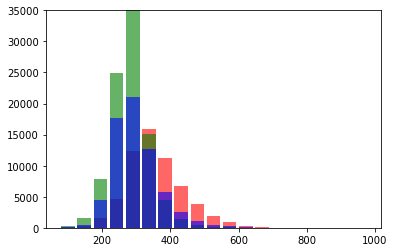

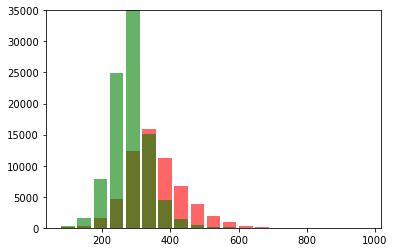

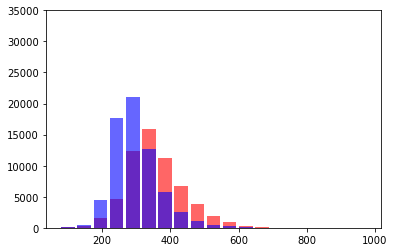

In [8]:
plt.bar(marks1[:-1],bin_counts1,width=40,alpha=0.6,color='r')
plt.bar(marks2[:-1],bin_counts2,width=40,alpha=0.6,color='g')
plt.bar(marks3[:-1],bin_counts3,width=40,alpha=0.6,color='b')
plt.ylim(0,35000)
plt.figure()
plt.bar(marks1[:-1],bin_counts1,width=40,alpha=0.6,color='r')
plt.bar(marks2[:-1],bin_counts2,width=40,alpha=0.6,color='g')
plt.ylim(0,35000)
plt.figure()
plt.bar(marks1[:-1],bin_counts1,width=40,alpha=0.6,color='r')
plt.bar(marks3[:-1],bin_counts3,width=40,alpha=0.6,color='b')
plt.ylim(0,35000)
plt.show()

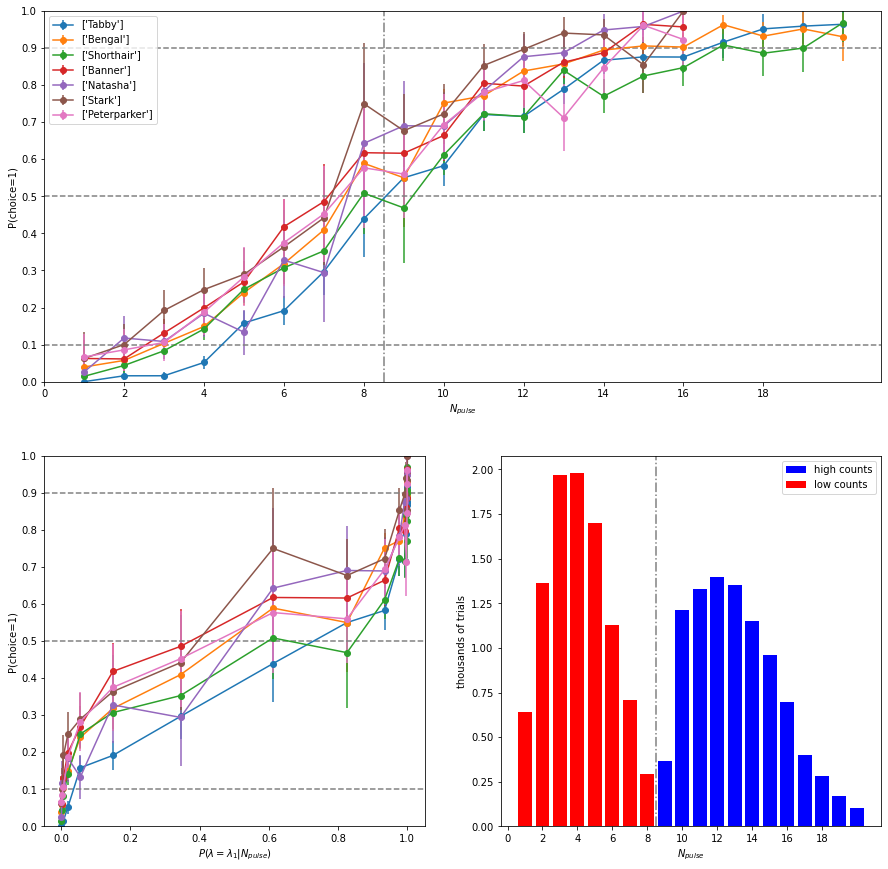

In [25]:
# Plot basic psychometric of each animal

fig = plt.figure(figsize=(15,15))
#fig.suptitle('Decision psychomatrics of pulse estimation',size=25)
animals_legend = animal_list
plt.subplot(2,1,1)

for i in range(len(phigh_list)):
    phigh = phigh_list[i]
    plt.errorbar(pulse_bins,y=phigh[:,0],yerr=phigh[:,1],marker='o',color=cmap[i])
plt.legend(animals_legend)
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')
plt.xticks(np.linspace(0,18,10))


plam_bins = calc_plam(pulse_bins,12.5,4.16667)
plt.subplot(2,2,3)
for i in range(len(phigh_list)):
    phigh = phigh_list[i]
    plt.errorbar(plam_bins,y=phigh[:,0],yerr=phigh[:,1],marker='o',color=cmap[i])
plt.xlabel('$P(\lambda=\lambda_1|N_{pulse})$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')

plt.subplot(2,2,4)
bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[half_num_bins:],bin_counts[half_num_bins:]/1000,color='b')
plt.bar(pulse_bins[:half_num_bins],bin_counts[:half_num_bins]/1000,color='r')
plt.legend(['high counts','low counts'])
plt.xticks(np.linspace(0,18,10))
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('$N_{pulse}$')
plt.ylabel('thousands of trials')

#fig.savefig('../../figures/20190523/behavior_summary.svg',format='svg')
#fig.savefig('../../figures/20190523/behavior_summary.png',format='png')
plt.show()

In [26]:
num_processes = 16
N_bootstrap = 4000
num_iter = 1000
batch_iter = 100
bound = (0.6,20)


bounds = list()
for i in range(20):
    bounds.append(bound)
num_batch = num_iter//batch_iter
resx_list = list()

for i in range(len(all_correct_trials_list)):
    res_array = np.zeros((20,num_iter))
    all_correct_trials = all_correct_trials_list[i]
    all_high_choices = all_high_choices_list[i]
    all_cum_odor = all_cum_odor_list[i]
    
    def worker(x):
        ind_bootstrap = np.random.randint(0,len(all_correct_trials),size=(N_bootstrap,))
        new_high_choices = all_high_choices[ind_bootstrap]
        new_cum_odor = all_cum_odor[ind_bootstrap]

        choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,18)

        def loss(x):
            Nb = x[0]
            sig_dN = x[1]
            sig_Np = x[2:]
            return -compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)

        x0 = 9.5+np.random.rand(20)*5
        res = minimize(loss,x0,bounds=bounds)
        return res.x

    output = list()
    
    with mp.Pool(processes=16) as pool:
        for i in tnrange(num_batch):
            batch_output = pool.map(worker,range(batch_iter))
            output.extend(batch_output)
        pool.close()

#     p = Pool(processes=16)
#     for i in tnrange(num_batch):
#         batch_output = p.map(worker,range(batch_iter))
#         output.extend(batch_output)
#     p.close()

    res_array = np.concatenate(output).reshape(-1,20).transpose()

    resx =np.zeros((20,2))
    resx[:,0] = res_array.mean(1)
    resx[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)
    resx_list.append(resx)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

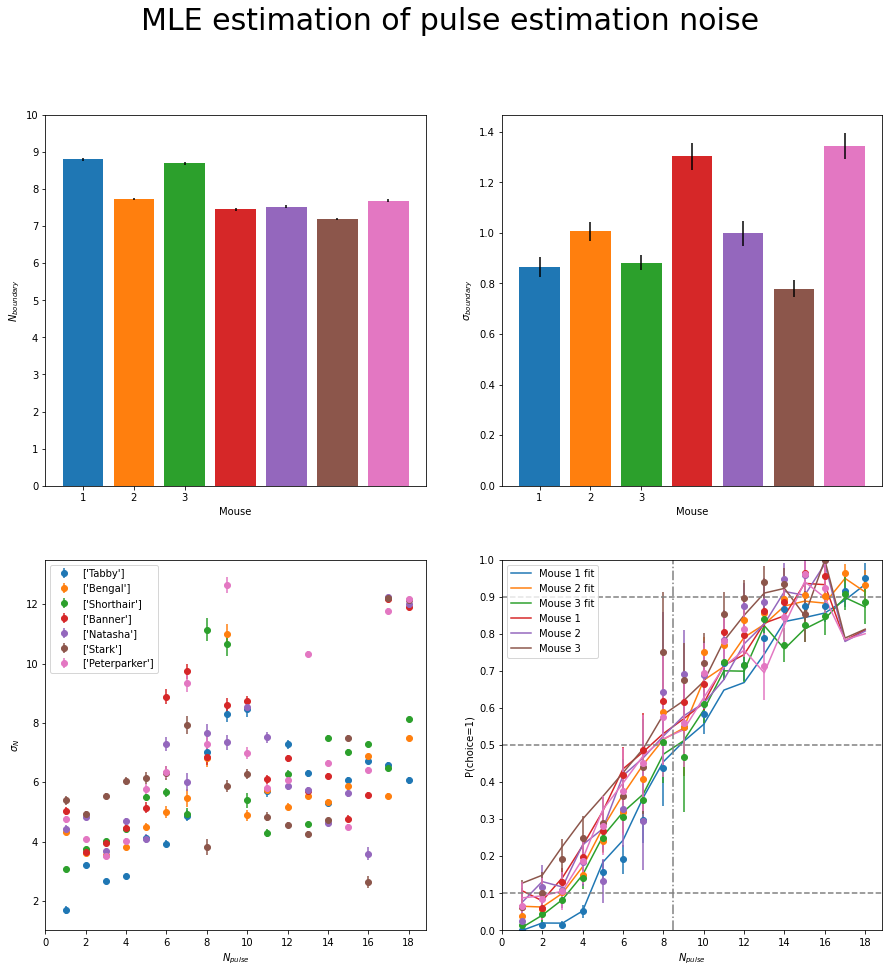

In [28]:
# plot noise estimation result

animals_legend = animal_list

fig = plt.figure(figsize=(15,15))
fig.suptitle('MLE estimation of pulse estimation noise',size=30)
plt.subplot(2,2,3)
Nb_array = np.zeros((len(resx_list),2))
sig_dN_array = np.zeros((len(resx_list),2))
for i in range(len(resx_list)):
    resx = resx_list[i]
    plt.errorbar(x=np.arange(1,19),y=resx[2:,0],yerr=resx[2:,1],marker='o',color=cmap[i],linestyle='')
    Nb_array[i,:] = resx[0,:]
    sig_dN_array[i,:] = resx[1,:]
plt.xticks(np.linspace(0,18,10))
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_{N}$')
plt.legend(animals_legend)
plt.subplot(2,2,1)
for i in range(len(resx_list)):
    plt.bar(x=i+1,height=Nb_array[i,0],yerr=Nb_array[i,1],color=cmap[i])
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,4))
plt.xlabel('Mouse')
plt.ylabel('$N_{boundary}$')

plt.subplot(2,2,2)
for i in range(len(resx_list)):
    plt.bar(x=i+1,height=sig_dN_array[i,0],yerr=sig_dN_array[i,1],color=cmap[i])
plt.xticks(np.arange(1,4))
plt.xlabel('Mouse')
plt.ylabel('$\sigma_{boundary}$')

plt.subplot(2,2,4)
for i in range(len(resx_list)):
    resx = resx_list[i]
    phigh = phigh_list[i]
    phigh_est = compute_phigh(np.arange(1,19),resx[0,0],resx[1,0],resx[2:,0])
    plt.plot(np.arange(1,19),phigh_est,color=cmap[i])
    plt.errorbar(np.arange(1,19),phigh[0:18,0],yerr=phigh[0:18,1],color=cmap[i],marker='o',linestyle='')
plt.xticks(np.linspace(0,18,10))
animals_legend2 = ['Mouse 1 fit','Mouse 2 fit','Mouse 3 fit','Mouse 1','Mouse 2','Mouse 3']
plt.legend(animals_legend2)
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')




#fig.savefig('../../figures/20190523/numeric_approximation_error_estimate.svg',format='svg')
#fig.savefig('../../figures/20190523/numeric_approximation_error_estimate.png',format='png')
plt.show()

In [29]:
pool_correct_trials = np.zeros((0,))
pool_high_choices = np.zeros((0,))
pool_cum_odor = np.zeros((0,))
for i in range(len(all_correct_trials_list)):
    pool_correct_trials = np.append(pool_correct_trials,all_correct_trials_list[i])
    pool_high_choices = np.append(pool_high_choices,all_high_choices_list[i])
    pool_cum_odor = np.append(pool_cum_odor,all_cum_odor_list[i])
    
phigh = np.zeros((num_bins,2))
performance = np.zeros((num_bins,2))
bin_counts = np.zeros((num_bins,))
pulse_bin_ind = np.ceil(pool_cum_odor).astype(np.int)

for i in range(num_bins):
    selected = pool_high_choices[pulse_bin_ind==pulse_bins[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind==pulse_bins[i]]
    num_selected = len(selected)
    bin_counts[i] = num_selected
    phigh[i,0] = selected.mean()
    phigh[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
    performance[i,0] = selected_correct.mean()
    performance[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)

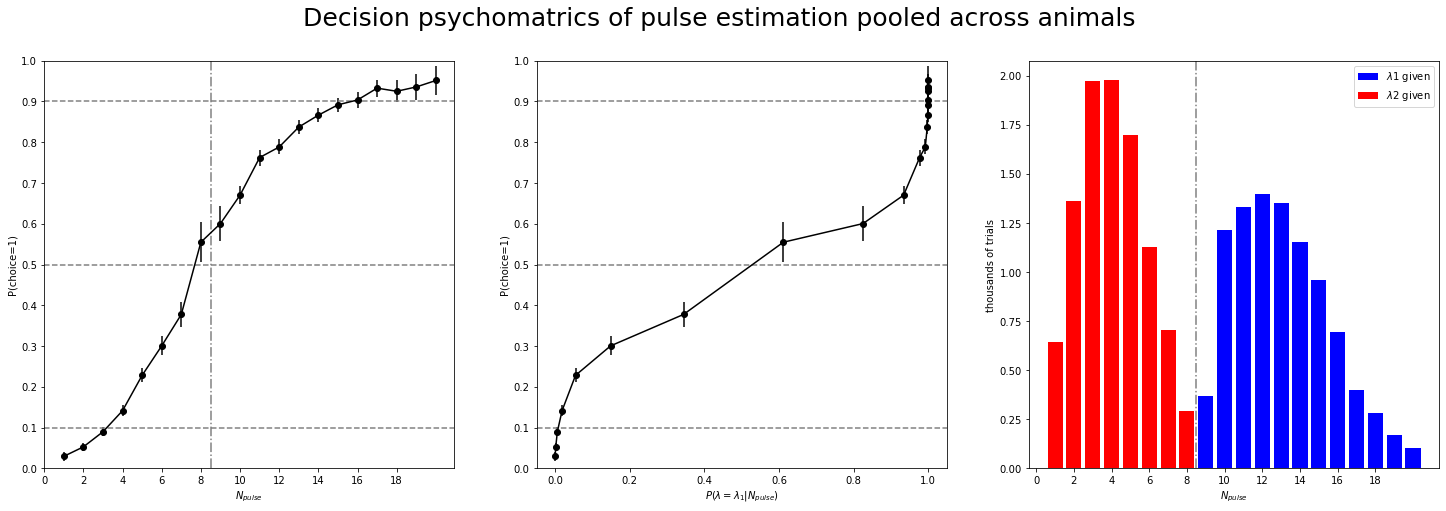

In [30]:
# Plot basic psychometric of pooled data

fig = plt.figure(figsize=(25,7.5))
fig.suptitle('Decision psychomatrics of pulse estimation pooled across animals',size=25)
plt.subplot(1,3,1)
plt.errorbar(x=pulse_bins,y=phigh[:,0],yerr=phigh[:,1],marker='o',color='black')
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')
plt.xticks(np.linspace(0,18,10))

plam_bins = calc_plam(pulse_bins,12.5,4.16667)
plt.subplot(1,3,2)

plt.errorbar(plam_bins,y=phigh[:,0],yerr=phigh[:,1],marker='o',color='black')
plt.xlabel('$P(\lambda=\lambda_1|N_{pulse})$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')

plt.subplot(1,3,3)
bin_counts = np.zeros((num_bins,))
for i in range(len(bin_counts_list)):
    bin_counts += bin_counts_list[i]
plt.bar(pulse_bins[half_num_bins:],bin_counts[half_num_bins:]/1000,color='b')
plt.bar(pulse_bins[:half_num_bins],bin_counts[:half_num_bins]/1000,color='r')
plt.legend(['$\lambda1$ given','$\lambda2$ given'])
plt.xticks(np.linspace(0,18,10))
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.xlabel('$N_{pulse}$')
plt.ylabel('thousands of trials')

#fig.savefig('../../figures/20190523/behavior_summary_pooled.svg',format='svg')
#fig.savefig('../../figures/20190523/behavior_summary_pooled.png',format='png')
plt.show()

In [ ]:
num_processes = 16
N_bootstrap = 10000
num_iter = 1000
batch_iter = 100
bound = (0.6,18)


bounds = list()
for i in range(20):
    bounds.append(bound)
num_batch = num_iter//batch_iter

res_array = np.zeros((20,num_iter))

    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,18)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        sig_Np = x[2:]
        return -compute_logp_correct(choices,Nps,Nb,sig_dN,sig_Np)

    x0 = 9.5+np.random.rand(20)*5
    res = minimize(loss,x0,bounds=bounds)
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,20).transpose()

resx_pool =np.zeros((20,2))
resx_pool[:,0] = res_array.mean(1)
resx_pool[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)

In [ ]:
# plot noise estimation result
fig = plt.figure(figsize=(25,7.5))
fig.suptitle('MLE estimation of pulse estimation noise pooled across animals',size=25)
plt.subplot(1,3,2)
Nb_array = np.zeros((1,2))
sig_dN_array = np.zeros((1,2))
for i in range(1):
    plt.errorbar(x=np.arange(1,19),y=resx_pool[2:,0],yerr=resx_pool[2:,1],marker='o',color='black',linestyle = '')
    Nb_array[i,:] = resx_pool[0,:]
    sig_dN_array[i,:] = resx_pool[1,:]
plt.xticks(np.linspace(0,18,10))
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_{N}$')
plt.subplot(1,3,1)
for i in range(1):
    plt.bar(x=i+1,height=Nb_array[i,0],yerr=Nb_array[i,1],color='gray')
    plt.bar(x=i+2,height=sig_dN_array[i,0],yerr=sig_dN_array[i,1],color='gray')
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,3),('$N_{boundary}$','$\sigma_{boundary}$'))
plt.xlabel('Mice Average')
plt.ylabel('$N_{boundary}$')

plt.subplot(1,3,3)

phigh_est = compute_phigh(np.arange(1,19),resx_pool[0,0],resx_pool[1,0],resx_pool[2:,0])
plt.errorbar(np.arange(1,19),phigh[:,0],yerr=phigh[:,1],color='black',marker='o',linestyle='')
plt.plot(np.arange(1,19),phigh_est,color='black')
    
plt.legend(['fit','real'])
plt.xticks(np.linspace(0,18,10))
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=9.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')




fig.savefig('../../figures/20190523/numeric_approximation_error_estimate_pooled.svg',format='svg')
fig.savefig('../../figures/20190523/numeric_approximation_error_estimate_pooled.png',format='png')
plt.show()

In [ ]:
x = np.concatenate([np.arange(1,8),np.arange(10,19)])
y = resx_pool[2:,0][x-1]
slope, intercept, r_value, p_value, std_err = linregress(x,y)
x_fit = np.linspace(0,20,21)
y_fit = x_fit * slope + intercept

slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x,y**2)
y_fit2 = x_fit * slope2 + intercept2

fig = plt.figure(figsize=(15,15))
fig.suptitle('Regression regression of pulse estimation noise',size=30)

plt.subplot(2,2,1)
plt.scatter(x,y,color='gray')
plt.plot(x_fit,y_fit,color='black')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,19)
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value,'real data'])
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N$')


plt.subplot(2,2,2)
phigh_est = compute_phigh(np.arange(1,19),resx_pool[0,0],resx_pool[1,0],y_fit[1:19])
plt.plot(np.arange(1,19),phigh_est,color='black')
plt.errorbar(np.arange(1,19),phigh[:,0],phigh[:,1],color='black',marker='o',linestyle='')
plt.xticks(np.linspace(0,18,10))
plt.legend(['linear fit','real'])
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')


plt.subplot(2,2,3)
plt.scatter(x,y**2,color='gray')
plt.plot(x_fit,y_fit2,color='black')
plt.xticks(np.linspace(0,20,11))
plt.xlim(0,19)
plt.legend(['linear fit ($R^2$ = %.2f)'%r_value2,'real data'])
plt.xlabel('$N_{pulse}$')
plt.ylabel('$\sigma_N^2$')

plt.subplot(2,2,4)
phigh_est = compute_phigh(np.arange(1,19),resx_pool[0,0],resx_pool[1,0],np.sqrt(y_fit2[1:19]))
plt.plot(np.arange(1,19),phigh_est,color='black')
plt.errorbar(np.arange(1,19),phigh[:,0],phigh[:,1],color='black',marker='o',linestyle='')
plt.legend(['sqrt fit','real'])
plt.xticks(np.linspace(0,18,10))
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')

fig.savefig('../../figures/20190523/linreg_noise.svg',format='svg')
fig.savefig('../../figures/20190523/linreg_noise.png',format='png')

plt.show()

In [ ]:
num_bins_long = 26
half_num_bins_long = int(num_bins/2)
min_pulse_long = 1
max_pulse_long = 26

pulse_bins_long = np.linspace(min_pulse_long,max_pulse_long,max_pulse_long-min_pulse_long+1)
phigh_long = np.zeros((num_bins_long,2))
performance_long = np.zeros((num_bins_long,2))
bin_counts_long = np.zeros((num_bins_long,))
pulse_bin_ind_long = np.ceil(pool_cum_odor).astype(np.int)

for i in range(num_bins_long):
    selected = pool_high_choices[pulse_bin_ind_long==pulse_bins_long[i]]
    selected_correct = pool_correct_trials[pulse_bin_ind_long==pulse_bins_long[i]]
    num_selected = len(selected)
    bin_counts_long[i] = num_selected
    phigh_long[i,0] = selected.mean()
    phigh_long[i,1] = 1.69*selected.std()/np.sqrt(num_selected)
    performance_long[i,0] = selected_correct.mean()
    performance_long[i,1] = 1.69*selected_correct.std()/np.sqrt(num_selected)

In [ ]:
num_processes = 16
N_bootstrap = 1000
num_iter = 1000
batch_iter = 100
bound = (1,18)


bounds = list()
for i in range(3):
    bounds.append(bound)
num_batch = num_iter//batch_iter

res_array = np.zeros((3,num_iter))

    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,18)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        return -compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig)

    x0 = 9.5+np.random.rand(3)*5
    
    res = minimize(loss,x0,bounds=bounds)
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,3).transpose()

resx_pool_sq =np.zeros((3,2))
resx_pool_sq[:,0] = res_array.mean(1)
resx_pool_sq[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)
phigh_est_sq = compute_phigh_sq(np.arange(1,27),resx_pool_sq[0,0],resx_pool_sq[1,0],resx_pool_sq[2,0],Nmax=26)

In [ ]:
num_processes = 16
N_bootstrap = 1000
num_iter = 1000
batch_iter = 100
bound = (1,18)


bounds = list()
for i in range(4):
    bounds.append(bound)
num_batch = num_iter//batch_iter

res_array = np.zeros((4,num_iter))

    
def worker(x):
    ind_bootstrap = np.random.randint(0,len(pool_correct_trials),size=(N_bootstrap,))
    new_high_choices = pool_high_choices[ind_bootstrap]
    new_cum_odor = pool_cum_odor[ind_bootstrap]

    choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,18)

    def loss(x):
        Nb = x[0]
        sig_dN = x[1]
        ksig = x[2]
        sig_0 = x[3]
        return -compute_logp_correct_lin(choices,Nps,Nb,sig_dN,ksig,sig_0)

    x0 = 9.5+np.random.rand(4)*5
    
    res = minimize(loss,x0,bounds=bounds)
    return res.x

output = list()

p = Pool(processes=16)
for i in tnrange(num_batch):
    batch_output = p.map(worker,range(batch_iter))
    output.extend(batch_output)
p.close()

res_array = np.concatenate(output).reshape(-1,4).transpose()

resx_pool_lin =np.zeros((4,2))
resx_pool_lin[:,0] = res_array.mean(1)
resx_pool_lin[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)
phigh_est_lin = compute_phigh_lin(np.arange(1,27),resx_pool_lin[0,0],resx_pool_lin[1,0],resx_pool_lin[2,0],resx_pool_lin[3,0],Nmax=26)

In [ ]:
fig = plt.figure(figsize=(15,15))
fig.suptitle('Square root MLE fit is the best fit',size=30)
plt.subplot(2,2,1)
x_long = np.arange(min_pulse_long,max_pulse_long+1)
slope2, intercept2, r_value2, p_value2, std_err2 = linregress(x,y**2)
y_fit_long1 = x_long*slope + intercept
y_fit_long2 = np.sqrt(x_long*slope2)
phigh_est_long1 = compute_phigh(x_long,resx_pool[0,0],resx_pool[1,0],y_fit_long1)
phigh_est_long2 = compute_phigh(x_long,resx_pool[0,0],resx_pool[1,0],y_fit_long2)
kl1 = entropy(phigh_est_long1,phigh_long[:,0])
kl2 = entropy(phigh_est_long2,phigh_long[:,0])
kl_sq = entropy(phigh_est_sq,phigh_long[:,0])
kl_lin = entropy(phigh_est_lin,phigh_long[:,0])

plt.plot(x_long,phigh_est_long1)
plt.plot(x_long,phigh_est_long2)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',linestyle='',color='black')
plt.legend(['linear scaling','square root scaling','real data'])
plt.ylim(0,1)
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')

plt.subplot(2,2,2)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
plt.plot(x_long,phigh_est_lin,color='black')
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')
plt.legend(['linear MLE fit','real data'])
plt.ylim(0,1)

plt.subplot(2,2,4)
plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
plt.plot(x_long,phigh_est_sq,color='black')
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')
plt.legend(['sqrt MLE fit','real data'])
plt.ylim(0,1)

plt.subplot(2,2,3)
plt.bar(1,kl1)
plt.bar(2,kl2)
plt.bar(3,kl_sq,color='gray')
plt.ylabel('KL Divergence to real data')
plt.xticks(np.arange(1,4),('linear','sqrt','sqrt MLE'))

fig.savefig('../../figures/20190523/fit_comparison.svg',format='svg')
fig.savefig('../../figures/20190523/fit_comparison.png',format='png')

plt.show()

In [ ]:
num_processes = 16
N_bootstrap = 4000
num_iter = 10000
batch_iter = 100
bound = (0.2,18)


bounds = list()
for i in range(3):
    bounds.append(bound)
num_batch = num_iter//batch_iter
resx_sq_list= list()

for i in range(len(all_correct_trials_list)):
    res_array = np.zeros((3,num_iter))
    all_correct_trials = all_correct_trials_list[i]
    all_high_choices = all_high_choices_list[i]
    all_cum_odor = all_cum_odor_list[i]
    
    def worker(x):
        ind_bootstrap = np.random.randint(0,len(all_correct_trials),size=(N_bootstrap,))
        new_high_choices = all_high_choices[ind_bootstrap]
        new_cum_odor = all_cum_odor[ind_bootstrap]

        choices,Nps = get_pulses(new_high_choices,new_cum_odor,1,18)

        def loss(x):
            Nb = x[0]
            sig_dN = x[1]
            ksig = x[2]
            return -compute_logp_correct_sq(choices,Nps,Nb,sig_dN,ksig)

        x0 = 9+np.random.rand(3)*5
        x0[1] = 4 + np.random.rand()*1
        res = minimize(loss,x0,bounds=bounds)
        return res.x

    output = list()

    p = Pool(processes=16)
    for i in tnrange(num_batch):
        batch_output = p.map(worker,range(batch_iter))
        output.extend(batch_output)
    p.close()

    res_array = np.concatenate(output).reshape(-1,3).transpose()

    resx_sq =np.zeros((3,2))
    resx_sq[:,0] = res_array.mean(1)
    resx_sq[:,1] = 1.69*res_array.std(1)/np.sqrt(num_iter)
    resx_sq_list.append(resx_sq)

In [ ]:
# plot noise estimation result

animals_legend = ['Mouse 1','Mouse 2','Mouse 3']

fig = plt.figure(figsize=(15,15))
fig.suptitle('MLE estimation of pulse estimation noise',size=30)

Nb_array = np.zeros((len(resx_sq_list),2))
sig_dN_array = np.zeros((len(resx_sq_list),2))
ksig_array = np.zeros((len(resx_sq_list),2))
for i in range(len(resx_sq_list)):
    resx = resx_sq_list[i]
    Nb_array[i,:] = resx[0,:]
    sig_dN_array[i,:] = resx[1,:]
    ksig_array[i,:] = resx[2,:]

plt.subplot(2,2,1)
for i in range(len(resx_sq_list)):
    plt.bar(x=i+1,height=Nb_array[i,0],yerr=Nb_array[i,1],color=cmap[i])
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,4))
plt.xlabel('Mouse')
plt.ylabel('$N_{boundary}$')

plt.subplot(2,2,2)
for i in range(len(resx_sq_list)):
    plt.bar(x=i+1,height=sig_dN_array[i,0],yerr=sig_dN_array[i,1],color=cmap[i])
plt.xticks(np.arange(1,4))
plt.xlabel('Mouse')
plt.ylabel('$\sigma_{boundary}$')

plt.subplot(2,2,3)
for i in range(len(resx_sq_list)):
    plt.bar(x=i+1,height=ksig_array[i,0],yerr=ksig_array[i,1],color=cmap[i])
plt.xticks(np.arange(1,4))
plt.xlabel('Mouse')
plt.ylabel('$k_{\sigma_N}$')

plt.subplot(2,2,4)
for i in range(len(resx_sq_list)):
    resx = resx_sq_list[i]
    phigh = phigh_list[i]
    phigh_est = compute_phigh(np.arange(1,19),resx[0,0],resx[1,0],resx[2:,0])
    plt.plot(np.arange(1,19),phigh_est,color=cmap[i])
    plt.errorbar(np.arange(1,19),phigh[:,0],yerr=phigh[:,1],color=cmap[i],marker='o',linestyle='')
animals_legend2 = ['Mouse 1 fit','Mouse 2 fit','Mouse 3 fit','Mouse 1','Mouse 2','Mouse 3']

plt.legend(animals_legend2)
plt.xticks(np.linspace(0,18,10))
plt.xlabel('$N_{pulse}$')
plt.axhline(y=0.1,color='gray',linestyle='--')
plt.axhline(y=0.5,color='gray',linestyle='--')
plt.axhline(y=0.9,color='gray',linestyle='--')
plt.axvline(x=8.5,color='gray',linestyle='-.')
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,11))
plt.ylabel('P(choice=1)')



fig.savefig('../../figures/20190523/numeric_approximation_error_estimate_sq.svg',format='svg')
fig.savefig('../../figures/20190523/numeric_approximation_error_estimate_sq.png',format='png')
plt.show()

In [ ]:
# plot noise estimation result
fig = plt.figure(figsize=(17,7.5))
#fig.suptitle('MLE estimation of pulse estimation noise pooled across animals',size=25)

plt.subplot(1,2,1)
for i in range(3):
    plt.bar(x=i+1,height=resx_pool_sq[i,0],yerr=resx_pool_sq[i,1],color='gray')
plt.yticks(np.arange(11))
plt.xticks(np.arange(1,4),('$N_{boundary}$','$\sigma_{boundary}$','$k_{\sigma_N}$'))
plt.ylabel('$N_{boundary}$')

plt.subplot(1,2,2)

plt.errorbar(x_long,phigh_long[:,0],yerr=phigh_long[:,1],marker='o',color='black',linestyle='')
plt.plot(x_long,phigh_est_sq,color='black')
plt.xticks(np.linspace(0,26,14))
plt.ylabel('P(choice=1)')
plt.xlabel('$N_{pulse}$')
plt.legend(['MLE fit','real data'])
plt.ylim(0,1)




fig.savefig('../../figures/20190523/numeric_approximation_error_estimate_pooled.svg',format='svg')
fig.savefig('../../figures/20190523/numeric_approximation_error_estimate_pooled.png',format='png')
plt.show()

In [ ]:
animal_list = [['Tabby'],['Bengal'],['Shorthair']]
fname_list = list()
for animals in animal_list:

    for date_number in range(20190419,20190520):
        for animal in animals:
            session_id = 0
            date_string = str(date_number)
            fname = animal + '_' + date_string + '_' + str(session_id) + '.pickle'
            cell_fname = 'session_' + fname
            if os.path.isfile(cell_fname):
                 fname_list.append(fname)

for i_file in range(len(fname_list)):
        session_id = 0
        fname = fname_list[i_file]
        session_fname = 'session_' + fname
        if os.path.isfile(session_fname):
            with open(session_fname,'rb') as handle:
                session_list = pickle.load(handle)
                session = session_list[0]
            num_trials = session['num_trials']
            non_idle_trials = np.invert(session['idle_trials'])
            
            performance = session['performance']
            correct_trials = session['correct_trials'][non_idle_trials]
            high_trials = session['high_trials'][non_idle_trials]
            low_trials = session['low_trials'][non_idle_trials]
            high_choices = (correct_trials==high_trials)
            trial_odor = session['trial_odor'][non_idle_trials]
            pre_breath = session['trial_pre_breath'][non_idle_trials]
            odor_breath = session['trial_breath'][non_idle_trials]
            
            savemat('matlab_data/'+fname.split('.')[0]+'.mat', {'num_trials':len(correct_trials),
                                                'high_trials':high_trials,
                                                'high_choices':high_choices,
                                                'correct_trials':correct_trials,
                                                'trial_odor':trial_odor,
                                                'pre_breath':pre_breath,
                                                'trial_breath':odor_breath})

In [ ]:
fname_list

In [ ]:
all_conv_odor.shape

In [6]:
for i in range(1):
    num_trials = session['num_trials']
    conv_odor = np.zeros((num_trials,5000))
    sniff_marks = np.zeros((10000,))
    sniff_kernel = np.load('inhalation_kernel_fine_weights_active.npy')
    for i_trial in range(1):
        sniff_raw = np.append(session['trial_pre_breath'][i_trial],session['trial_breath'][i_trial])
        sniff = butter_lowpass_filter(sniff_raw,3,1000,3)
        sniff = (sniff - sniff.mean() +1)/2
        sniff_onset,_ = find_peaks(-sniff,distance=100)
        sniff_onset = sniff_onset[sniff_onset>2250]
        sniff_onset = sniff_onset[sniff_onset<7750]
        sniff_markers = np.zeros((10000,))
        conv_weights = np.zeros((10000,))
        for i in range(len(sniff_onset)-1):
            nsample = sniff_onset[i+1]-sniff_onset[i]
            conv_weights[sniff_onset[i]:sniff_onset[i+1]] = resample(sniff_kernel,nsample)*250
        sniff_markers[sniff_onset] = 1
        sniff_sampling_epoch = sniff[2500:7500]
        conv_weights_sampling_epoch = conv_weights[2500:7500]
        odor_command = session['trial_odor'][0]
        odor = get_odor_profile_actual(odor_command)[0:5000]
        odor_effective = odor*conv_weights_sampling_epoch
        conv_odor[i_trial,:] = odor_effective

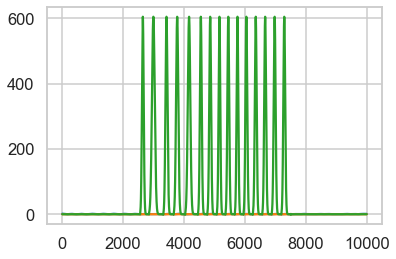

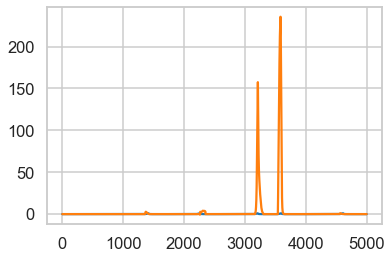

In [7]:
plt.plot(sniff)
plt.plot(sniff_markers)
plt.plot(conv_weights)
plt.figure()
plt.plot(odor)
plt.plot(odor_effective)
plt.show()

In [208]:
high_odor = all_conv_odor[all_high_trials.astype(np.bool)].mean(axis=1)
low_odor = all_conv_odor[np.invert(all_high_trials.astype(np.bool))].mean(axis=1)
high_odor_d = all_conv_odor[all_high_choices.astype(np.bool)].mean(axis=1)
low_odor_d = all_conv_odor[np.invert(all_high_choices.astype(np.bool))].mean(axis=1)


19.239385158590018

In [194]:
high_odor.max()

38.1928262538324

In [209]:
bins = np.linspace(0,40,21)
high_counts, marks = np.histogram(high_odor,bins=bins)
low_counts, marks = np.histogram(low_odor,bins=bins)
high_counts_d, marks = np.histogram(high_odor_d,bins=bins)
low_counts_d, marks = np.histogram(low_odor_d,bins=bins)

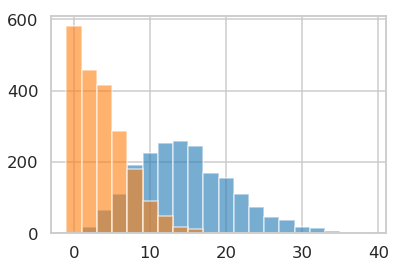

In [207]:
plt.bar(bins[:-1],high_counts,width=2,alpha=0.6)
plt.bar(bins[:-1],low_counts,width=2,alpha=0.6)
plt.show()

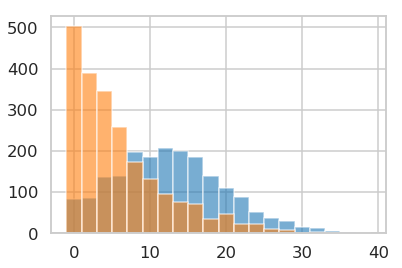

In [210]:
plt.bar(bins[:-1],high_counts_d,width=2,alpha=0.6)
plt.bar(bins[:-1],low_counts_d,width=2,alpha=0.6)
plt.show()

In [226]:
test_trial = all_conv_odor[7,:].copy()

In [228]:
test_trial2 = test_trial.copy()

In [229]:
test_trial2[test_trial2<100]=0

(array([ 153,  576, 1620, 2379, 3660]), {})

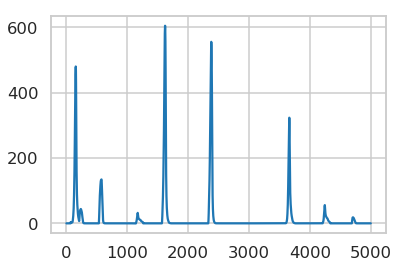

In [237]:
plt.plot(test_trial)
find_peaks(test_trial2)

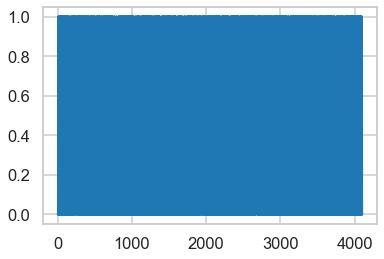

In [89]:
plt.plot(all_high_choices)

In [3]:
norm_given_odor = (all_cum_odor-all_cum_odor.mean())/all_cum_odor.std()
norm_inhaled_odor = (all_cum_conv_odor-all_cum_conv_odor.mean())/all_cum_conv_odor.std()

In [4]:
bins = np.linspace(-3,6,31)
all_low_choices = np.logical_not(all_high_choices)
bar_label = (bins[1:]+bins[:-1])/2
odor_counts, marks = np.histogram(norm_given_odor,bins=bins)
odor_counts_l, marks = np.histogram(norm_given_odor[all_low_trials.astype(bool)],bins=bins)
odor_counts_h, marks = np.histogram(norm_given_odor[all_high_trials.astype(bool)],bins=bins)
odor_counts_cl, marks = np.histogram(norm_given_odor[all_low_choices.astype(bool)],bins=bins)
odor_counts_ch, marks = np.histogram(norm_given_odor[all_high_choices.astype(bool)],bins=bins)

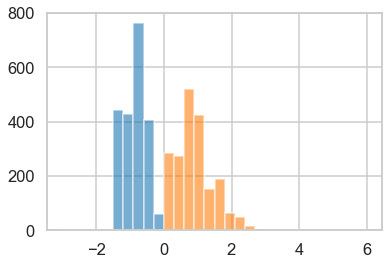

In [287]:
plt.bar(bar_label,odor_counts_l,width=0.3,alpha=0.6)
plt.bar(bar_label,odor_counts_h,width=0.3,alpha=0.6)
plt.show()

# 

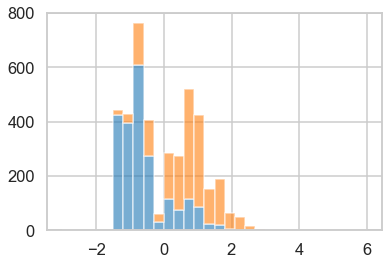

In [5]:
plt.bar(bar_label,odor_counts_cl,width=0.3,alpha=0.6)
plt.bar(bar_label,odor_counts_ch,bottom=odor_counts_cl,width=0.3,alpha=0.6)
plt.show()

In [7]:
odor_counts_i, marks = np.histogram(norm_inhaled_odor,bins=bins)
odor_counts_il, marks = np.histogram(norm_inhaled_odor[all_low_trials.astype(bool)],bins=bins)
odor_counts_ih, marks = np.histogram(norm_inhaled_odor[all_high_trials.astype(bool)],bins=bins)
odor_counts_icl, marks = np.histogram(norm_inhaled_odor[all_low_choices.astype(bool)],bins=bins)
odor_counts_ich, marks = np.histogram(norm_inhaled_odor[all_high_choices.astype(bool)],bins=bins)

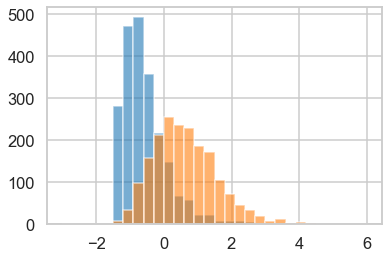

In [297]:
plt.bar(bar_label,odor_counts_icl,width=0.3,alpha=0.6)
plt.bar(bar_label,odor_counts_ich,width=0.3,alpha=0.6)
plt.show()

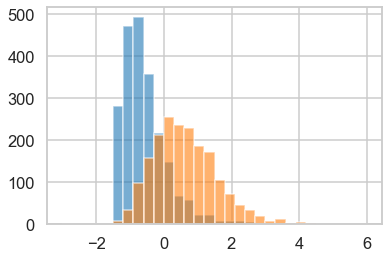

In [303]:
plt.bar(bar_label,odor_counts_icl,width=0.3,alpha=0.6)
plt.bar(bar_label,odor_counts_ich,width=0.3,alpha=0.6)
plt.show()

In [19]:
all_high_choices[np.logical_and(norm_inhaled_odor>0,norm_inhaled_odor>0)].mean()

0.7980493402180149

In [24]:
all_low_choices[np.logical_and(norm_given_odor<0,norm_inhaled_odor<0)].mean()

0.8646496815286624

In [34]:
all_low_trials[np.logical_and(norm_given_odor<0,norm_inhaled_odor>1.3)]

array([ True])

In [8]:
np.minimum(odor_counts_il,odor_counts_ih).sum()/odor_counts.sum()

0.16282491417361453

In [9]:
np.minimum(odor_counts_icl,odor_counts_ich).sum()/odor_counts.sum()

0.21186856302108878

In [312]:
all_correct_trials.mean()

0.801863658656204

In [334]:
all_low_trials[np.logical_and(norm_given_odor<0,norm_inhaled_odor>0)].sum()

212

In [333]:
np.logical_and(norm_given_odor<0,norm_inhaled_odor>0).sum()

212